In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# Jupiter magic command, read above
%matplotlib inline

### NQ - September 19, 2000 to July 11, 2022

Getting data ready

In [2]:
df = pd.read_csv('../data/Yahoo_NQ_daily_20000919_20220711.csv')
df[:9]

,Date,Close
0,2022-07-11,11884.25
1,2022-07-08,12152
2,2022-07-07,12138.5
3,2022-07-06,11880.25
4,2022-07-05,11808.5
5,2022-07-04,-
6,2022-07-01,11611.25
7,2022-06-30,11529.5
8,2022-06-29,11691


In [3]:
df.tail()

,Date,Close
5549,2000-09-25,3675
5550,2000-09-22,3776
5551,2000-09-21,3765
5552,2000-09-20,3853
5553,2000-09-19,3804


In [4]:
# Dates are a string right now
print(type(df['Date'][0]))
# Convert to date Timestamp
df['Date'] = pd.to_datetime(df['Date'])
print(type(df['Date'][0]))

<class 'str'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [5]:
# Holidays show '-' as a value, like July 4h. We want to fill those rows with the average value of the previous day and the day after.

# Convert column 'Data' to numeric, setting invalid values to NaN
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
# Fill NaN values with the average value of the previous day and the day after.
df['Close'] = df['Close'].interpolate(method='linear')
df[:9]

,Date,Close
0,2022-07-11,11884.250
1,2022-07-08,12152.000
2,2022-07-07,12138.500
3,2022-07-06,11880.250
4,2022-07-05,11808.500
5,2022-07-04,11709.875
6,2022-07-01,11611.250
7,2022-06-30,11529.500
8,2022-06-29,11691.000


In [6]:
# We want to sort the dataframe in ascending Dates and reset the index
df = df.sort_values(by='Date').reset_index(drop=True) 
df[:9]

,Date,Close
0,2000-09-19,3804.0
1,2000-09-20,3853.0
2,2000-09-21,3765.0
3,2000-09-22,3776.0
4,2000-09-25,3675.0
5,2000-09-26,3611.5
6,2000-09-27,3645.0
7,2000-09-28,3758.0
8,2000-09-29,3621.0


In [7]:
df[-9:]

,Date,Close
5545,2022-06-29,11691.000
5546,2022-06-30,11529.500
5547,2022-07-01,11611.250
5548,2022-07-04,11709.875
5549,2022-07-05,11808.500
5550,2022-07-06,11880.250
5551,2022-07-07,12138.500
5552,2022-07-08,12152.000
5553,2022-07-11,11884.250


Data is now ready

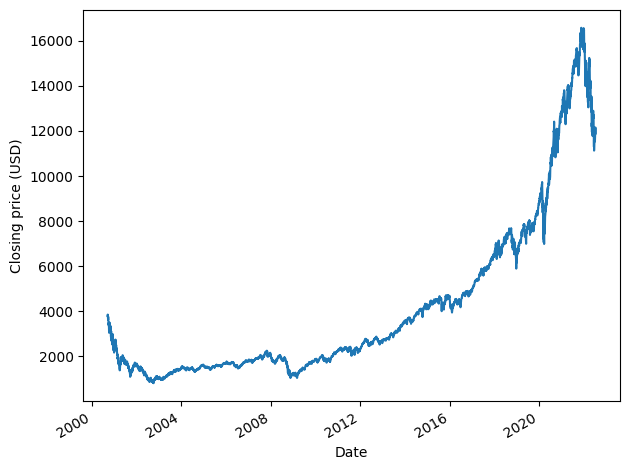

In [8]:
# NQ - September 19, 2000 to July 11, 2022

fig, ax = plt.subplots()

ax.plot(df['Date'], df['Close'])
ax.set_xlabel('Date')
ax.set_ylabel('Closing price (USD)')

fig.autofmt_xdate()
plt.tight_layout()

In [9]:
# Testing for Stationarity
ADF_result = adfuller(df['Close'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')
# ADF Statistic = -2.32 (is not a large negative number) and p-value = 0.16 (greater than 0.05), thus we cannot reject the null hypothesis (non-stationarity), 
# thus the NQ series is non-stationary

ADF Statistic: 0.8662381407129758
p-value: 0.9926335217815211


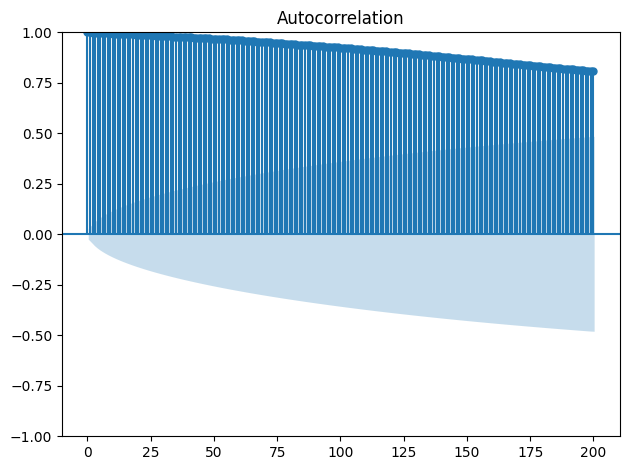

In [10]:
# ACF plot does not apply, but interesting how it does keep showing correlation all the way in a non-stationary process

plot_acf(df['Close'], lags=200)

plt.tight_layout()

In [11]:
# First-order differencing

first_order_diff = np.diff(df['Close'], n=1)

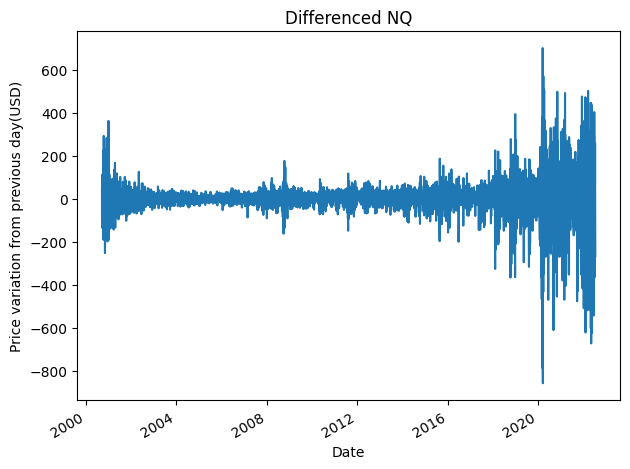

In [12]:
# First-order differencing plot

fig, ax = plt.subplots()

ax.plot(df['Date'][1:], first_order_diff)
ax.set_xlabel('Date')
ax.set_ylabel('Price variation from previous day(USD)')

plt.title('Differenced NQ')
fig.autofmt_xdate()
plt.tight_layout()

In [13]:
# Testing for Stationarity
ADF_result = adfuller(first_order_diff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')
# ADF Statistic = -13.12 (is a large negative number) and p-value = 0.00 (smaller than 0.05), thus we can reject the null hypothesis (non-stationarity), 
# thus the first-order differencing of NQ series is stationary

ADF Statistic: -13.008432512123806
p-value: 2.598163807800346e-24


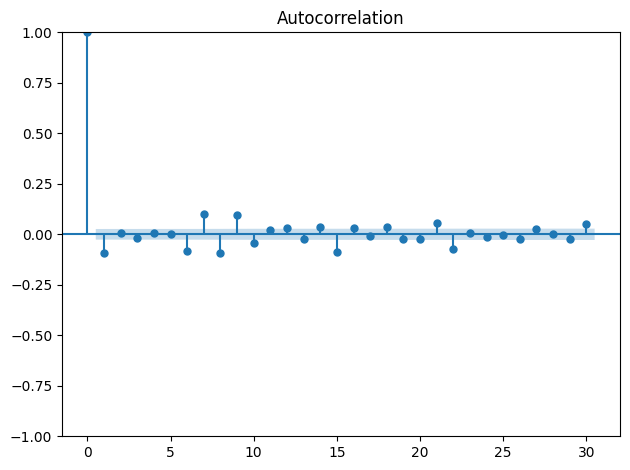

In [14]:
# Plot ACF to check for correlation

plot_acf(first_order_diff, lags=30)

plt.tight_layout()

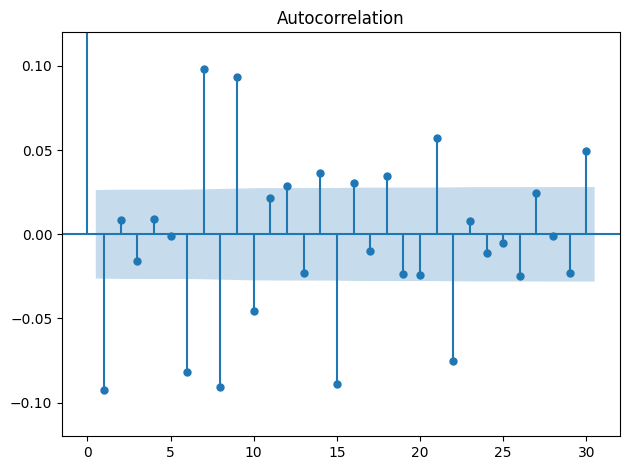

In [15]:
# Plot ACF to check for correlation - Zoom

plot_acf(first_order_diff, lags=30)

plt.ylim(-0.12, 0.12)

plt.tight_layout()

Stationary but not fully uncorrelated, quite though

NQ cannot be approximated as a random walk process, because it shows several significant coefficients

In [16]:
train = df[:-5]
test = df[-5:]

In [17]:
# Predict the historical mean

mean = np.mean(train['Close'])

test.loc[:, 'pred_mean'] = mean

test.head()

,Date,Close,pred_mean
5549,2022-07-05,11808.50,4091.815797
5550,2022-07-06,11880.25,4091.815797
5551,2022-07-07,12138.50,4091.815797
5552,2022-07-08,12152.00,4091.815797
5553,2022-07-11,11884.25,4091.815797


In [18]:
# Predict the last value

last_value = train['Close'].iloc[-1]

test.loc[:, 'pred_last'] = last_value

test.head()

,Date,Close,pred_mean,pred_last
5549,2022-07-05,11808.50,4091.815797,11709.875
5550,2022-07-06,11880.25,4091.815797,11709.875
5551,2022-07-07,12138.50,4091.815797,11709.875
5552,2022-07-08,12152.00,4091.815797,11709.875
5553,2022-07-11,11884.25,4091.815797,11709.875


In [19]:
# Predict with the drift method
# Drift method: same historical average rate of change, same historical slope

deltaX = len(train) - 1
deltaY = last_value - train['Close'].iloc[0]

drift = deltaY / deltaX

x_vals = np.arange(5549, 5554, 1)

pred_drift = drift * x_vals + train['Close'].iloc[0]

test.loc[:, 'pred_drift'] = pred_drift

test.head()

,Date,Close,pred_mean,pred_last,pred_drift
5549,2022-07-05,11808.50,4091.815797,11709.875,11711.299995
5550,2022-07-06,11880.25,4091.815797,11709.875,11712.724991
5551,2022-07-07,12138.50,4091.815797,11709.875,11714.149986
5552,2022-07-08,12152.00,4091.815797,11709.875,11715.574982
5553,2022-07-11,11884.25,4091.815797,11709.875,11716.999977


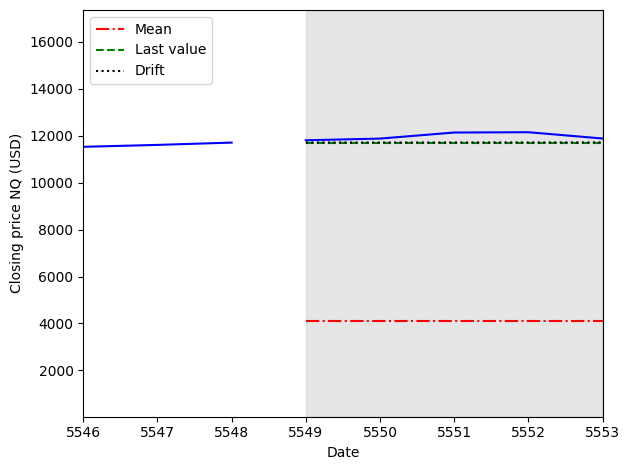

In [20]:
# Plot forecasts by naive methods

fig, ax = plt.subplots()

ax.plot(train['Close'], 'b-')
ax.plot(test['Close'], 'b-')
ax.plot(test['pred_mean'], 'r-.', label='Mean')
ax.plot(test['pred_last'], 'g--', label='Last value')
ax.plot(test['pred_drift'], 'k:', label='Drift')

ax.axvspan(5549, 5553, color='#808080', alpha=0.2)
ax.legend(loc=2)

ax.set_xlabel('Date')
ax.set_ylabel('Closing price NQ (USD)')

#ax.set_xlim(5540, 5553)
plt.xlim(5546, 5553)

plt.tight_layout()

In [21]:
# MSE of predictions

from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['Close'], test['pred_mean'])
mse_last = mean_squared_error(test['Close'], test['pred_last'])
mse_drift = mean_squared_error(test['Close'], test['pred_drift'])

print(mse_mean, mse_last, mse_drift)

62128929.86334667 89671.015625 87204.95397755942


##### Forecasting the next timestep 

Specifically, we will predict the last known value

In [22]:
df_shift = df.shift(periods=1)

df_shift.head()

,Date,Close
0,NaT,NaN
1,2000-09-19,3804.0
2,2000-09-20,3853.0
3,2000-09-21,3765.0
4,2000-09-22,3776.0


In [23]:
# Pg 54, MSE of the prediction of the test set

mse_one_step = mean_squared_error(test['Close'], df_shift['Close'][-5:])

mse_one_step

30688.065625

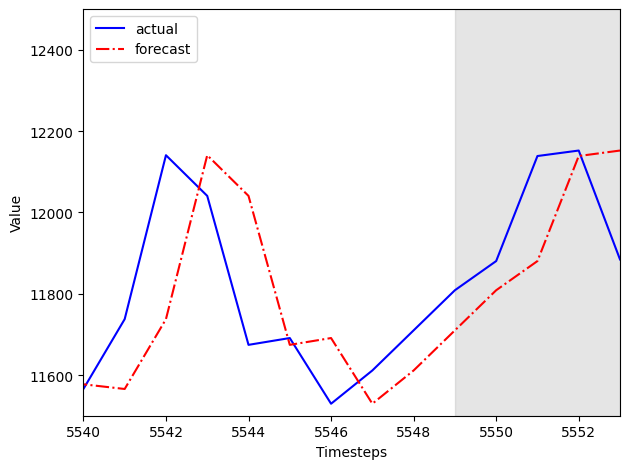

In [24]:
fig, ax = plt.subplots()

ax.plot(df['Close'], 'b-', label='actual')
ax.plot(df_shift['Close'], 'r-.', label='forecast')

ax.axvspan(5549, 5553, color='#808080', alpha=0.2)
ax.legend(loc=2)

ax.set_xlim(5540, 5553)
ax.set_ylim(11500, 12500)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()

Note: 

Over-differencing makes your model less parsimonious (unnecessarily complex) and can make forecasts less stable. It forces the model to work harder to "cancel out" the artificial noise you introduced, which often leads to poor predictive performance. 

To verify this, try comparing the standard deviation of your original series versus your differenced series; if it increased after differencing, you should likely stick with the original data.

********************************************************************************************************
Should I compare CV instead? Coefficient of Variation, CV = Standard Deviation / Mean
While the Coefficient of Variation (\(CV=\frac{\sigma }{\mu }\)) is great for comparing the relative dispersion of two different datasets, it often fails in time series differencing for two reasons:  
The Mean Approaches Zero: When you difference a series, the new mean (\(\mu \)) often drops to nearly zero. This causes the CV to explode toward infinity, making the comparison mathematically unstable.  
Negative Means: Differenced data can have negative means, which makes the CV conceptually meaningless.
********************************************************************************************************

********************************************************************************************************
The Better Metric:   
Standard Deviation of \(d=1\) vs \(d=2\) The "Variance Rule" is most effective when comparing \(d=1\) vs \(d=2\), rather than comparing the original raw data to the first difference.   
At the stage where you are deciding between first-order and second-order differencing, the means are usually on a similar scale (often close to zero), making a direct comparison of Standard Deviation (\(\sigma \)) or Variance (\(\sigma ^{2}\)) much more reliable. 
********************************************************************************************************

In [29]:
# Let's check variance before (df) and after differencing (first_order_diff)

# Coefficient of Variation, CV = Standard Deviation / Mean

Sigma_before = df['Close'].std()
Sigma_after_1 = first_order_diff.std()

print(f'Standard deviation before the transformation is {Sigma_before}, and after the transformation is {Sigma_after_1}.')

second_order_diff = np.diff(df['Close'], n=2)
Sigma_after_2 = second_order_diff.std()

print(f'Standard deviation after first-order transformation is {Sigma_after_1}, and after second-order transformation is {Sigma_after_2}.')

Standard deviation before the transformation is 3660.5789301546483, and after the transformation is 82.05340417281387.
Standard deviation after first-order transformation is 82.05340417281387, and after second-order transformation is 121.2306756605625.


That would be overdifferencing